In [1]:
# imports
import re
import sys
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from itertools import product
from functools import partial


# constants
MIN_T = 3
MAX_T = 28
min_t = pd.Timedelta(days=MIN_T)
max_t = pd.Timedelta(days=MAX_T)

In [2]:
# RAW DFS
islts = pd.read_excel('PLT_all_stool_isolates.xlsx')
xmd = pd.read_excel('map.samples_20221028_Yael.xlsx', index_col=0)
xmd.rename(columns={'StudyID': 'StoolID'}, inplace=True)
islts.rename(columns = {'Stool ID':'StoolID', 'VRE +/-':'VRE'}, inplace = True)
islts = islts[islts.StudyID.notnull()] #lose 2 samples
islts = islts[~islts.ESBLisolate.apply(lambda v: type(v) is str and "SAME AS" in v)]#remove 4 duplciates



# clean mdro type vars
islts['ESBL'] = islts.ESBLisolate.replace([0, 'N', 'No', '-', 'n', 'N (NO MAC GROWTH)', 'N (ODD)'], 'No').\
    replace(['?', '35379- FALSE + DUE TO BAD PLATES', '35387 (FALSE + DUE TO BAD PLATES)',
            '35393 (FALSE + DUE TO BAD PLATES)'], np.nan).\
     apply(lambda v: np.nan if type(v) is str and 'BOTH FALSE + DUE TO BAD PLATES' in v else v)

islts['KPC'] = islts.KPCisolate.replace(['N', 'n', '-', 0, 'N (AFTER SUB CX)', 'N (NO MAC GROWTH)'], 'No').\
                 replace(['?', 'N (SMALL BLUE?)', '?N '], np.nan)

islts['VRE'] = islts.VRE.replace(['N', '-', 'n', '0'], 'No').replace(['+ (NEG on reculture 3/31)', 'NEG on reculture 4/12'], np.nan).\
    replace(['+', '+ (not pink)', '+ (mauve + blue)', '+ (pink + white)', '+ (mauve)', '+ (white)'], 'Yes')

islts = islts.drop(['ESBLisolate', 'KPCisolate'], axis = 1)

missing = [302615, 303205, 303955, 304362, 311175, 31117, 312645, 319365, 320275, 320315, 320515, 320525, 32073, 32077, 32088, 32089, 32090, 32096, 32098, 32101, 32106, 32107, 32108, 32119, 32138, 32141, 321481, 321482, 32152, 32173, 32177, 32184, 32196, 32197, 32198, 32221, 32235, 32238]
print(len(missing))
stlbk = pd.read_excel('StoolBookDeidentified20241023.xlsx')
stlbk.rename({'Stool_ID': 'StoolID'}, inplace=True, axis=1)
stlbk = stlbk.loc[stlbk.StoolID.isin(missing), :].drop(['ESBL_Growth', 'KPC_Growth', 'VRE_Growth'], axis=1)
mkstr = lambda x: f'{int(x)},' if pd.notna(x) else ''
stlbk['VRE'] = stlbk.apply(lambda r: 'No' if r[['VRE1', 'VRE2', 'VRE3']].isnull().all() else mkstr(r.VRE1)+mkstr(r.VRE2)+mkstr(r.VRE3), axis=1).apply(lambda x: x[:-1] if x.endswith(',') else x)
stlbk['ESBL'] = stlbk.apply(lambda r: 'No' if r[['ESBL1', 'ESBL2', 'ESBL3']].isnull().all() else mkstr(r.ESBL1)+mkstr(r.ESBL2)+mkstr(r.ESBL3), axis=1).apply(lambda x: x[:-1] if x.endswith(',') else x)
stlbk['KPC'] = stlbk.apply(lambda r: 'No' if r[['KPC1', 'KPC2', 'KPC3']].isnull().all() else mkstr(r.KPC1)+mkstr(r.KPC2)+mkstr(r.KPC3), axis=1).apply(lambda x: x[:-1] if x.endswith(',') else x)
stlbk.drop(['VRE1', 'VRE2', 'VRE3', 'ESBL1', 'ESBL2', 'ESBL3', 'KPC1', 'KPC2', 'KPC3'], axis=1, inplace=True)
stlbk['TxDate'] = stlbk.StudyID.apply(lambda x: islts.loc[islts.StudyID == int(x), 'TxDate'].iloc[0] if not islts.loc[islts.StudyID == int(x), 'TxDate'].empty else pd.NaT)
stlbk.rename({'Sample_Date':'SampleDate'}, axis=1, inplace=True)
print(islts.shape)
print(stlbk.shape)
islts = pd.concat([islts, stlbk])
print(islts.shape)

# ADD SEQUENCE INFO
r = pd.read_pickle('RawMetadata.df')
islts['StoolIDstr'] = islts.StoolID.astype(str)
islts['seq2020'] = islts.StoolIDstr.isin(r[r.index.get_level_values(1) == '2020'].index.get_level_values(0))
islts['seq2022'] = islts.StoolIDstr.isin(r[r.index.get_level_values(1) == '2022'].index.get_level_values(0))
islts['seq2023'] = islts.StoolIDstr.isin(r[r.index.get_level_values(1) == '2023'].index.get_level_values(0))
islts['seqALL'] = islts['seq2020'] | islts['seq2022'] | islts['seq2023']
#islts['seqALL'] = False
islts = islts.merge(r.groupby(level=0).sum()[['PostHGFRC2']], left_on='StoolIDstr', right_index=True, how = 'left')
islts = islts.drop('StoolIDstr', axis = 1)
islts

dups = islts.groupby(['StudyID', 'SampleDate']).apply(lambda x: x[x.seqALL] if (len(x) > 1 and x.seqALL.any()) else None)
sngltns = islts.groupby(['StudyID', 'SampleDate']).apply(lambda x: x if len(x) == 1 else None)
islts = pd.concat([sngltns, dups]).reset_index(drop=True)
islts.to_excel('sample_metadata.xlsx')
islts[['StoolID', 'StudyID']].to_excel('sample_metadata_StoolStudy.xlsx')
# CHECK THAT WHAT WE'RE DROPPING IS THE NON_SEQ DUPLICATES
##PTNT 186 IS WEIRD W 31331 31332
#dupstlid = [31012, 30522, 30100, 30176, 30947, 30327, 30483, 30496, 30919, 31098, 
#            31332, 30973, 31277, 31820, 31501, 31899, 31828, 31884, 31808, 32033]
#islts = islts[~islts.StoolID.isin(dupstlid)]
#islts.shape
#PATH_TO_PE_EXT = '/manitou/pmg/projects/korem_lab/Projects/ACU_PLT/mmmbp2/tmp_path2/EXT/extended_contigs'
#islts['PATH'] = islts.StoolID.apply(lambda x: f'{PATH_TO_PE_EXT}/{x}.pe_ext.fasta')
#
#
#
#ABX
abx  = pd.read_excel('PLT_Abx_Courses_Tal2.xlsx').iloc[:, :4]
tx = islts[['TxDate', 'StudyID']].dropna().drop_duplicates()
tx.index = tx.StudyID
tx = tx.TxDate
abx['course_start_date'] = abx.apply(lambda r: tx[r.StudyID] + pd.Timedelta(days=r.course_start_daysposttx), axis=1)
abx['course_end_date'] = abx.apply(lambda r: tx[r.StudyID] + pd.Timedelta(days=r.course_end_daysposttx), axis=1)
abx['course_duration'] = (abx.course_end_daysposttx - abx.course_start_daysposttx) + 1
total_abx_exp = abx.sort_values('StudyID').groupby('StudyID').course_duration.sum()
total_abx_exp.name = 'total_abx_exposure'
abx = abx.merge(total_abx_exp, how='left', left_on='StudyID', right_index=True)
#abx
#
print('num na: ', islts[['ESBL', 'VRE', 'KPC']].isna().sum().sum())
islts[islts[['ESBL', 'VRE', 'KPC']].isna().any(axis=1)].to_excel('samples_with_NA_culture_result.xlsx')
#islts.ESBL = islts.ESBL.apply(lambda x: '30000' if pd.isna(x) else x)
#islts.VRE = islts.VRE.apply(lambda x: '30000' if pd.isna(x) else x)
#islts.KPC = islts.KPC.apply(lambda x: '30000' if pd.isna(x) else x)

# ADD XMD
islts = islts.merge(xmd, on='StoolID', how='left')
islts.to_excel('sample_metadata_withxmd.xlsx')
islts['in_xmd'] = islts.StoolID.isin(xmd.index).astype(bool)
SIGNAL_VARIABLES = ['meldtxp', 'meld_hilo', 'ctp_score', 'ctp_class', 'PeriOpAbx_Adj', 'Post_Biliary_Stricture'] + [e for e in islts.columns if '14dprior' in e]
list(SIGNAL_VARIABLES)

38
(2056, 7)
(25, 7)
(2081, 7)


/tmp/ipykernel_179172/2932136236.py:54: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  dups = islts.groupby(['StudyID', 'SampleDate']).apply(lambda x: x[x.seqALL] if (len(x) > 1 and x.seqALL.any()) else None)
/tmp/ipykernel_179172/2932136236.py:55: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sngltns = islts.groupby(['StudyID', 'SampleDate']).apply(lambda x: x if len(x) == 1 else None)


num na:  145


['meldtxp',
 'meld_hilo',
 'ctp_score',
 'ctp_class',
 'PeriOpAbx_Adj',
 'Post_Biliary_Stricture',
 'Aminoglycoside_14dprior',
 'Group.1.B.lactam_14dprior',
 'Group.2.B.lactam_14dprior',
 'Group.3.B.lactam_14dprior',
 'Carbapenems_14dprior',
 'B.Lactam.no.penems.ALL_14dprior',
 'B.Lactam.ALL_14dprior',
 'Glyco..Lipo.peptide_14dprior',
 'Quinolone_14dprior',
 'Tetracycline_14dprior',
 'Other_14dprior',
 'Rifaximin_14dprior',
 'Oral.Vancomycin_14dprior']

In [ ]:
#islts_avail = islts.loc[islts.in_xmd & islts.seqALL, :].sort_values('StudyID').groupby('StudyID').apply(lambda x: x.iloc[0,:])
#list(islts_avail.columns)

['meldtpx', 'meld_hilo', 'ctp_score', 'ctp_class', 'PeriOpAbx_Adj', 'Post_Biliary_Stricture', 'Aminoglycoside_14dprior', 'Group.1.B.lactam_14dprior', 'Group.2.B.lactam_14dprior', 'Group.3.B.lactam_14dprior', 'Carbapenems_14dprior', 'B.Lactam.no.penems.ALL_14dprior', 'B.Lactam.ALL_14dprior', 'Glyco..Lipo.peptide_14dprior', 'Quinolone_14dprior', 'Tetracycline_14dprior', 'Other_14dprior', 'Rifaximin_14dprior', 'Oral.Vancomycin_14dprior']


/tmp/ipykernel_6688/1464207597.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  islts_avail = islts.loc[islts.in_xmd & islts.seqALL, :].sort_values('StudyID').groupby('StudyID').apply(lambda x: x.iloc[0,:])


In [166]:
# XMD analysis
# meldtpx - meld at time of transplant
# meldhilo - is categorical of meldtpx
# ctp_score - at time of transplant
# case labels: how yael descriped case and control
# cant touch tacro
# biliary stricture  - how well things connect
# this abx variables defines whether they receeived a dose of the antibiotic within two weeks before sample date.
# pero-op-adjustment, this is wether they have been adjusted from the standard course. Strong outcome found with this. 


# some abx are taken oral, some are taken IV, it's perhpas a good way to separate amongst these. This is not always
# carbapenem, glycolipopeptide, 


# make map_samples_X_metadata - this contains the original metadata without variables added from yael. 
# make use of this and then go back to reference Yael table if there's stuff missing. 



# xmd.StudyID == islts.StoolID
#print(xmd.loc[xmd.index.intersection(islts_seq.StoolID)].shape)

# xmd.UID == islts.StudyID
#xmd.loc[:, ['14dprior' in e for e in xmd.columns]]
#xmd_avail = xmd.loc[xmd.UID.isin(islts.StudyID), :]
#xmd_avail.sort_values('UID').groupby('UID').apply(lambda x: x.iloc[0,:])

In [91]:
# ABX FUNCTIONS
def course_days_to_date(abx_df, date):
    if abx_df.empty:
        return np.nan
    days = abx_df.loc[abx_df.course_end_date < date, 'course_duration'].sum()
    days = pd.Timedelta(days=days)
    if any((abx_df.course_start_date <= date) & (date <= abx_df.course_end_date)):
        days += (date - abx_df.loc[(abx_df.course_start_date <= date) & (date <= abx_df.course_end_date), :].course_start_date).sum() + pd.Timedelta(days=1)
    return days.days

def days_since_last_exposure(abx_df, date):
    if abx_df.empty:
        return np.nan
    if any((abx_df.course_start_date <= date) & (date <= abx_df.course_end_date)):
        # sample taken during exposure
        return 0
    if any(abx_df.course_end_date < date):
        return (date - abx_df.loc[abx_df.course_end_date < date,'course_end_date']).min().days
    
def days_exposure_btwn(abx_df, sample, future):
    if abx_df.empty:
        return np.nan
    ovlp_s = abx_df.course_start_date.apply(lambda x: max(x, sample))
    ovlp_e = abx_df.course_end_date.apply(lambda x: min(x, future))
    ovlp = (ovlp_e - ovlp_s).apply(lambda x: 0 if x.days < 0 else x.days + 1)
    return ovlp.sum()
    

In [90]:
# METADATA AND OUTCOME FUNCTIONS

def get_vars(mdro_span, drop_clear_or_positive, g):
    StudyID = g.name
    g = g.sort_values('SampleDate')
    g['Clear'] = (g[mdro_span] == 'No').all(axis=1)
    g['Positive'] = g[mdro_span].apply(lambda v: (v != 'No') & pd.notnull(v), axis=1).any(axis=1)
    if drop_clear_or_positive:
        g = g[(g[['Clear', 'Positive']] == True).any(axis=1)]
    gj = g.join(g.shift(-1), rsuffix='_nxt')
    gj['tx_to_sample_days'] = (gj.SampleDate - gj.TxDate).apply(lambda x: x.days)
    gj['sample_to_future_days'] = (gj.SampleDate_nxt - gj.SampleDate).apply(lambda x: x.days)
    gj['course_days_total'] = abx.loc[abx.StudyID == StudyID, 'course_duration'].sum()
    gj['course_days_to_sample'] = gj.apply(lambda r: course_days_to_date(abx.loc[abx.StudyID == StudyID,:], r.SampleDate), axis=1)
    gj['course_days_to_future'] = gj.apply(lambda r: course_days_to_date(abx.loc[abx.StudyID == StudyID, :], r.SampleDate_nxt), axis=1)
    gj['course_days_since_last_exposure'] = gj.apply(lambda r: days_since_last_exposure(abx.loc[abx.StudyID == StudyID, :], r.SampleDate), axis=1)
    gj['course_days_between'] = gj.apply(lambda r: days_exposure_btwn(abx.loc[abx.StudyID == StudyID, :], r.SampleDate, r.SampleDate_nxt), axis=1)
    #print(gj.to_string())
    return gj

def get_outcome(w, timetx, maxabx, clrlgc, seqstat, min_reads, is_positive, g):
    g = g.sort_values('SampleDate')
    w_filt  = (w[0] <= g.sample_to_future_days) & (g.sample_to_future_days <= w[1])
    
    
    tx_filt =  (timetx[0] <= g.tx_to_sample_days) & (g.tx_to_sample_days <= timetx[1])
    # if you don't care allow nan
    if timetx == (-np.inf, np.inf):
        tx_filt |= g.tx_to_sample_days.isna()
    
    abx_filt = g.course_days_between <= maxabx
    # if you don't care, allow nan
    if maxabx == np.inf:
        abx_filt |= g.course_days_between.isna()
    
    mrd_filt = g.PostHGFRC2 >= min_reads
    if seqstat is None:
        mdr_filt = np.full((g.shape[0],), True)

    if is_positive:
        pos_filt = g.Positive
    else:
        pos_filt = ~g.Positive

    
    if seqstat == 'seqALL':
        seq_filt = g.seqALL
    elif seqstat == 'seq2023':
        seq_filt = g.seq2023
    elif seqstat == 'seq2022':
        seq_filt = g.seq2022
    elif seqstat == 'seq2020':
        seq_filt = g.seq2020
    elif seqstat is None:
        seq_filt = np.full((g.shape[0],), True)
    else:
        raise Exception
    
    filt = w_filt & abx_filt & tx_filt & pos_filt & seq_filt & mrd_filt
        
    #print('remaining:',  (w_filt & tx_filt & abx_filt & seq_filt).sum())
    if clrlgc == 'allclr':
        outcome = g.apply(lambda r: 'Clearance' if r['Clear_nxt'] == True else 'Persistence' if r['Positive_nxt'] == True else np.nan, axis = 1)
        outcome.loc[~filt] = np.nan
    elif clrlgc == 'typedclr':
        outcome = g.apply(lambda r: 'Persistence' if any(np.all(np.vstack([r[['VRE_nxt', 'KPC_nxt', 'ESBL_nxt']].apply(lambda x: x != 'No' and pd.notnull(x)), r[['VRE', 'KPC', 'ESBL']].apply(lambda x: x != 'No' and pd.notnull(x))]), axis=0)) else 'Clearence', axis = 1)
        outcome.loc[~filt] = np.nan
    elif clrlgc == 'allemerge':
        outcome = g.apply(lambda r: 'NoEmergence' if r['Clear_nxt'] == True else 'Emergence' if r['Positive_nxt'] == True else np.nan, axis=1)
        outcome.loc[~filt] = np.nan
    else:
        raise Exception
    return outcome
    
def allclr(g):
    g = g.sort_values('SampleDate')
    g = g[(g[['Clear', 'Positive']] == True).any(axis=1)]
    gj = g.join(g.shift(-1), rsuffix='_nxt')
    gj = gj[((gj.SampleDate_nxt - gj.SampleDate) >= min_t) & ((gj.SampleDate_nxt - gj.SampleDate) <= max_t)]
    gj['Outcome'] = gj.apply(lambda r: 'Clearance' if r['Clear_nxt'] == True else 'Persistence' if r['Positive_nxt'] == True else np.nan, axis = 1)
    #print(gj.to_string())
    return gj

def spfcclr(g):
    g = g.sort_values('SampleDate')
    g = g[(g[['Clear', 'Positive']] == True).any(axis=1)]
    gj = g.join(g.shift(-1), rsuffix='_nxt')
    gj = gj[((gj.SampleDate_nxt - gj.SampleDate) >= min_t) & ((gj.SampleDate_nxt - gj.SampleDate) <= max_t)]
    gj['Outcome'] = gj.apply(lambda r: 'Persistence' if any(np.all(np.vstack([r[['VRE_nxt', 'KPC_nxt', 'ESBL_nxt']].apply(lambda x: x != 'No' and pd.notnull(x)), r[['VRE', 'KPC', 'ESBL']].apply(lambda x: x != 'No' and pd.notnull(x))]), axis=0)) else 'Clearence', axis = 1)
    return gj

def allmerge(g):
    g = g.sort_values('SampleDate')
    g = g[(g[['Clear', 'Positive']] == True).any(axis=1)]
    gj = g.join(g.shift(-1), rsuffix='_nxt')
    gj['Outcome'] = gj.apply(lambda r: 'Persistence' if any(np.all(np.vstack([r[['VRE_nxt', 'KPC_nxt', 'ESBL_nxt']].apply(lambda x: x != 'No' and pd.notnull(x)), r[['VRE', 'KPC', 'ESBL']].apply(lambda x: x != 'No' and pd.notnull(x))]), axis=0)) else 'Clearence', axis = 1)
    return gj

#def get_outcome(g):
#    g = g.sort_values('SampleDate')
#    g = g[(g[['Clear', 'Positive']] == True).any(axis=1)]
#    gj = g.join(g.shift(-1), rsuffix='_nxt')
#    gj = gj[((gj.SampleDate_nxt - gj.SampleDate) >= min_t) & ((gj.SampleDate_nxt - gj.SampleDate) < max_t)]
#    gj['Outcome'] = gj.apply(lambda r: 'Clearance' if r['Clear_nxt'] == True else 'Persistence' if r['Positive_nxt'] == True else np.nan, axis = 1)
#    return gj

In [405]:
mdro_span = ['VRE', 'ESBL', 'KPC']
gv = partial(get_vars, mdro_span, True)
outcome = islts.groupby('StudyID').apply(gv, include_groups=False).reset_index().drop('level_1', axis=1)
outcome_fun = partial(get_outcome, (3,56), (-np.inf, np.inf), np.inf, 'allemerge', 'seqALL', 5*10**6, False)
outcome['allemerge'] = outcome.groupby('StudyID').apply(outcome_fun, include_groups=False).reset_index().drop(['StudyID', 'level_1'], axis=1)

/tmp/ipykernel_6688/3509482040.py:3: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  outcome = islts.groupby('StudyID').apply(gv, include_groups=False).reset_index().drop('level_1', axis=1)


In [370]:
outcome[outcome.seqALL & ~outcome.Positive]['Positive_nxt'].value_counts()

Positive_nxt
False    191
True      57
Name: count, dtype: int64

In [406]:
outcome[outcome.allemerge.notnull()].to_csv('allemerge_3-56.csv')
outcome[outcome.allemerge.notnull()][['StoolID', 'StudyID', 'allemerge']].to_csv('allemerge_3-56_outcome.csv')

In [ ]:
mdro_span = ['VRE', 'ESBL', 'KPC']
gv = partial(get_vars, mdro_span, False)
outcome = islts.groupby('StudyID').apply(gv, include_groups=False).reset_index().drop('level_1', axis=1)

/tmp/ipykernel_6688/3222053811.py:3: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  outcome = islts.groupby('StudyID').apply(gv, include_groups=False).reset_index().drop('level_1', axis=1)


In [342]:
# MDX VARIABLE ANALYSIS

def write_md_and_outcome(df, filename, varname):
    df.to_csv(f'{filename}_md.csv', index=None)
    df = df[['StoolID', 'StudyID', varname]]
    df.columns = ['StoolID', 'StudyID', 'outcome']
    df.to_csv(f'{filename}_outcome.csv')

MIN_READS=5*10**6
##sns.histplot(outcome.course_days_to_sample)
#abxload = outcome[outcome.course_days_to_sample.notnull() & outcome.seqALL]
#abxload = abxload[(0 <= abxload.tx_to_sample_days) & (abxload.tx_to_sample_days <= 14)]
#abxload = abxload[abxload.PostHGFRC2 >= MIN_READS]
#abxload = abxload.groupby('StudyID').apply(lambda x: x.sort_values('SampleDate').iloc[0,:], include_groups=False).reset_index()
#write_md_and_outcome(abxload, 'abxload', 'course_days_to_sample')
#print(abxload.shape)
##sns.histplot(outcome.course_days_to_sample)
## note that, now we removed the Clear or Positive constraint, we get three more samples. So, 87
## instead of 84, hence why metadata construction is commented out
##outcome.to_csv('abx_load_metadata.csv')
#
#print(SIGNAL_VARIABLES)
#
## MELDTXP
outcome_in_xmd = outcome.loc[outcome.seqALL & outcome.in_xmd]
##sns.histplot(meldtpx.course_days_to_sample)
meldtxp = outcome_in_xmd[(-7 <= outcome_in_xmd.tx_to_sample_days) & (outcome_in_xmd.tx_to_sample_days <= 14)]
meldtxp = meldtxp[meldtxp.PostHGFRC2 >= MIN_READS]
meldtxp = meldtxp[meldtxp['meldtxp'].notnull()]
meldtxp = meldtxp.groupby('StudyID').apply(lambda x: x.sort_values('SampleDate').iloc[0,:], include_groups=False).reset_index()
write_md_and_outcome(meldtxp, 'meldtxp', 'meldtxp')
print(meldtxp.shape)

# MELD HILO
meld_hilo = outcome_in_xmd[(-7 <= outcome_in_xmd.tx_to_sample_days) & (outcome_in_xmd.tx_to_sample_days <= 14)]
meld_hilo = meld_hilo[meld_hilo.PostHGFRC2 >= MIN_READS]
meld_hilo = meld_hilo[meld_hilo['meld_hilo'].notnull()]
meld_hilo = meld_hilo.groupby('StudyID').apply(lambda x: x.sort_values('SampleDate').iloc[0,:], include_groups=False).reset_index()
write_md_and_outcome(meld_hilo, 'meld_hilo', 'meld_hilo')
print(meld_hilo.shape)


# CTPSCORE
ctp_score = outcome_in_xmd[(-7 <= outcome_in_xmd.tx_to_sample_days) & (outcome_in_xmd.tx_to_sample_days <= 14)]
ctp_score = ctp_score[ctp_score.PostHGFRC2 >= MIN_READS]
ctp_score = ctp_score[ctp_score['ctp_score'].notnull()]
ctp_score = ctp_score.groupby('StudyID').apply(lambda x: x.sort_values('SampleDate').iloc[0,:], include_groups=False).reset_index()
write_md_and_outcome(ctp_score, 'ctp_score', 'ctp_score')
print(ctp_score.shape)

# CTPCLASS
ctp_class = outcome_in_xmd[(-7 <= outcome_in_xmd.tx_to_sample_days) & (outcome_in_xmd.tx_to_sample_days <= 14)]
ctp_class = ctp_class[ctp_class.PostHGFRC2 >= MIN_READS]
ctp_class = ctp_class[ctp_class['ctp_class'].notnull()]
ctp_class = ctp_class.groupby('StudyID').apply(lambda x: x.sort_values('SampleDate').iloc[0,:], include_groups=False).reset_index()
write_md_and_outcome(ctp_class, 'ctp_class', 'ctp_class')

## PeriOpAbx_Adj
#periop = outcome_in_xmd[(0 <= outcome_in_xmd.tx_to_sample_days) & (outcome_in_xmd.tx_to_sample_days <= 14)]
#periop = periop[periop.PostHGFRC2 >= MIN_READS]
#periop = periop[periop['PeriOpAbx_Adj'].notnull()]
#periop = periop.groupby('StudyID').apply(lambda x: x.sort_values('SampleDate').iloc[0,:], include_groups=False).reset_index()
#write_md_and_outcome(periop, 'periop', 'PeriOpAbx_Adj')
#print(periop.shape)
#sns.histplot(periop.tx_to_sample_days)
#
#pbstric = outcome_in_xmd[(0 <= outcome_in_xmd.tx_to_sample_days) & (outcome_in_xmd.tx_to_sample_days <= 14)]
#pbstric = pbstric[pbstric.PostHGFRC2 >= MIN_READS]
#pbstric = pbstric[pbstric['Post_Biliary_Stricture'].notnull()]
#pbstric = pbstric.groupby('StudyID').apply(lambda x: x.sort_values('SampleDate').iloc[0,:], include_groups=False).reset_index()
#write_md_and_outcome(pbstric, 'pbstric', 'Post_Biliary_Stricture')
#print(pbstric.shape)
#sns.histplot(pbstric.tx_to_sample_days)
#
#
#for sv in SIGNAL_VARIABLES[6:]:
#    print(sv)
#    df = outcome_in_xmd[outcome_in_xmd.PostHGFRC2 >= MIN_READS]
#    df = df[df[sv].notnull()]
#    df = df.groupby('StudyID').apply(lambda x: x.sort_values('SampleDate').iloc[0,:], include_groups=False).reset_index()
#    write_md_and_outcome(df, sv, sv)
#    print(df.shape)





# note that, now we removed the Clear or Positive constraint, we get three more samples. So, 87
# instead of 84, hence why metadata construction is commented out
#outcome.to_csv('abx_load_metadata.csv')



(76, 344)
(76, 344)
(76, 344)


<Axes: xlabel='total_abx_exposure', ylabel='Count'>

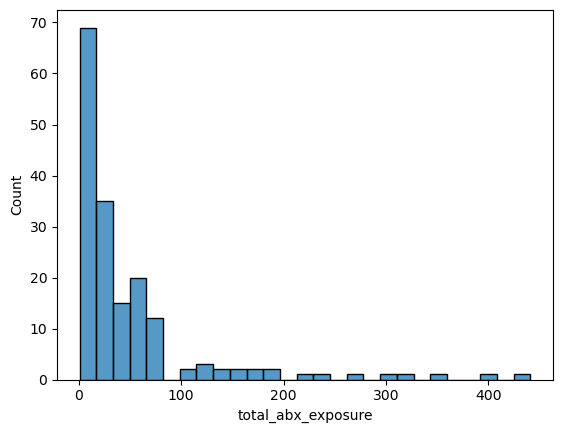

In [36]:
exp_per_pat = abx.groupby('StudyID').total_abx_exposure.unique().apply(lambda x: x[0])
sns.histplot(exp_per_pat)


(87, 344)


/tmp/ipykernel_6688/2251763846.py:58: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  outcome = islts.groupby('StudyID').apply(gv, include_groups=False).reset_index().drop('level_1', axis=1)


<Axes: xlabel='course_days_to_sample', ylabel='Count'>

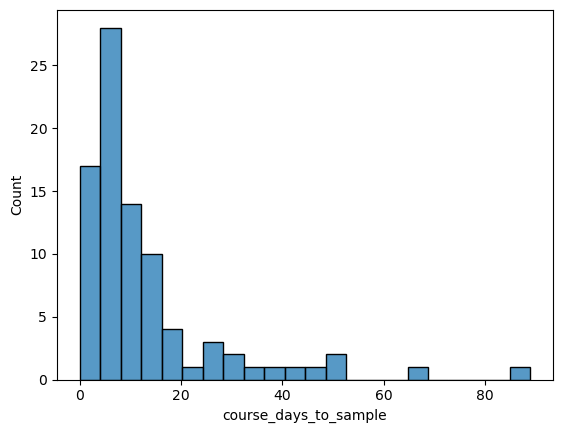

In [241]:
## GRID COMPUTE METADATA
MIN_READS=5*10**6
#MIN_SAMPLES=30
#MIN_LEAST_REPR_LABEL=10
## ALL MDRO
#windows = [(3, 14)]#, (3, 21), (7, 21), (7, 28), (3, 14)]
#time_from_tx = [(-np.inf, np.inf)]
#abxbtwn = [np.inf]
#clearance_logic = ['allclr']
#seq_stat = ['seqALL']#, 'seq2022']#, None]
#mdro_span = ['VRE', 'ESBL', 'KPC']
#gv = partial(get_vars, mdro_span)
#outcome = islts.groupby('StudyID').apply(gv, include_groups=False).reset_index().drop('level_1', axis=1)
## CHECK: Will get 614 in Tal version when selecting Positive samples but commenting out window filter
#for w, timetx, maxabx, clrlgc, sqst in product(windows, time_from_tx, abxbtwn, clearance_logic, seq_stat):
#    # CHECK: when adding the window filter (3, 28), and selecting seq_stat None, you get 323, matching Tal version
#    time_txnm = f'{timetx[0]}-{timetx[1]}' if timetx != (-np.inf, np.inf) else ('any')
#    outcome_t = f'Outcome_allmdro_{clrlgc}_tx{time_txnm}_abx{maxabx if maxabx != np.inf else "any"}_w{w[0]}-{w[1]}_{sqst}'
#    outcome_fun = partial(get_outcome, w, timetx, maxabx, clrlgc, sqst, MIN_READS)
#    outcome[outcome_t] = outcome.groupby('StudyID').apply(outcome_fun, include_groups=False).reset_index().drop(['StudyID', 'level_1'], axis=1)
#    if outcome[outcome_t].notna().sum() < MIN_SAMPLES or outcome[outcome_t].dropna().value_counts().min() < MIN_LEAST_REPR_LABEL:
#        print('SKIPPED: ', outcome_t, outcome[outcome_t].notna().sum(), 'samples')
#        outcome.drop(columns=[outcome_t], inplace=True)
#        continue
#    print('Samples: ', outcome[outcome_t].dropna().shape[0])
#    print('Patients: ', len(outcome[outcome[outcome_t].notna()].StudyID.value_counts()))
#    print(outcome[outcome_t].dropna().value_counts())
#outcome.to_csv('Outcome_allmdro.csv', index=None)
    
    
## VRE SPECIFIC
#windows = [(3, 28)]#, (3, 21), (7, 21), (7, 28), (3, 14)]
#time_from_tx = [(-np.inf, np.inf), (0, 28)]
#abxbtwn = [np.inf]
#clearance_logic = ['allclr']
#seq_stat = ['seq2023']#, 'seq2020', None]
#mdro_span = ['VRE']
#gv = partial(get_vars, mdro_span)
#outcome_vre = islts.groupby('StudyID').apply(gv, include_groups=False).reset_index().drop('level_1', axis=1)
#print('samples:', outcome_vre[outcome_vre.Positive].shape[0])
#for w, timetx, maxabx, clrlgc, sqst in product(windows, time_from_tx, abxbtwn, clearance_logic, seq_stat):
#    time_txnm = f'{timetx[0]}-{timetx[1]}' if timetx != (-np.inf, np.inf) else ('any')
#    outcome_t = f'Outcome_vremdro_{clrlgc}_tx{time_txnm}_abx{maxabx if maxabx != np.inf else "any"}_w{w[0]}-{w[1]}_{sqst}'
#    outcome_fun = partial(get_outcome, w, timetx, maxabx, clrlgc, sqst)
#    outcome_vre[outcome_t] = outcome_vre.groupby('StudyID').apply(outcome_fun, include_groups=False).reset_index().drop(['StudyID', 'level_1'], axis=1)
#    if outcome_vre[outcome_t].notna().sum() < MIN_SAMPLES:
#        print('SKIPPED: ', outcome_t, outcome_vre[outcome_t].notna().sum(), 'samples')
#        outcome_vre.drop(columns=[outcome_t], inplace=True)
#        continue
#    print(outcome_vre[outcome_t].dropna().shape)
#    print(outcome_vre[outcome_t].dropna().value_counts())
#outcome_vre.to_csv('Outcome_vremdro.csv', index=None)


# ABX LOAD
mdro_span = ['VRE', 'ESBL', 'KPC']
gv = partial(get_vars, mdro_span, False)
outcome = islts.groupby('StudyID').apply(gv, include_groups=False).reset_index().drop('level_1', axis=1)
outcome = outcome[outcome.course_days_to_sample.notnull()]
outcome = outcome[outcome.seqALL]
#sns.histplot(outcome.course_days_to_sample)
outcome = outcome[(0 <= outcome.tx_to_sample_days) & (outcome.tx_to_sample_days <= 14)]
outcome = outcome[outcome.PostHGFRC2 >= MIN_READS]
outcome = outcome.groupby('StudyID').apply(lambda x: x.sort_values('SampleDate').iloc[0,:], include_groups=False).reset_index()
print(outcome.shape)
sns.histplot(outcome.course_days_to_sample)
#outcome.to_csv('abx_load_metadata.csv')

In [120]:

#outcome[outcome['Outcome_allmdro_allclr_txany_abxany_w3-28_seqALL'].notna()].to_excel('subset.xlsx')
out_csv = outcome[outcome['Outcome_allmdro_allclr_txany_abxany_w3-14_seqALL'].notna()].groupby('StudyID').apply(lambda x: x.iloc[0,:], include_groups=False).reset_index()
out_csv.to_csv('TaskF_ospp.csv', index=None)
out_csv = outcome[outcome['Outcome_allmdro_allclr_txany_abxany_w3-14_seqALL'].notna()].groupby('StudyID').apply(lambda x: x.iloc[0,:], include_groups=False).reset_index()[['StoolID', 'StudyID','Outcome_allmdro_allclr_txany_abxany_w3-14_seqALL']]
out_csv.to_csv('TaskF_ospp.outcome.csv', index=None)


In [198]:


#missing_from_stlbk = [e for e in missing if not any(stlbk.StoolID.isin([e]))]
#print(len(missing_from_stlbk))
#missing_from_stlbk

38


,StoolID,Sample_Date,StudyID,VRE,ESBL,KPC,TxDate
1049,31117,2016-04-04,230.0,No,No,No,2016-03-31
1954,32073,2019-11-14,396.0,No,No,No,NaT
1958,32077,2019-11-21,405.0,No,35985,No,NaT
1967,32088,2020-01-14,405.0,35987,35986,No,NaT
1968,32089,2020-01-14,421.0,No,No,No,NaT
1969,32090,2020-01-14,414.0,No,No,No,NaT
1974,32096,2020-01-29,405.0,No,No,No,NaT
1976,32098,2020-02-03,403.0,36009,No,No,NaT
1979,32101,2020-02-10,264.0,No,No,No,NaT
1983,32106,2020-02-21,398.0,No,No,No,NaT


In [154]:
islts.loc[islts.StoolID == 30004]

,StoolID,SampleDate,StudyID,TxDate,VRE,seq2023,seq2020,seq2022,seqALL,PostHGFRC2,ESBL,KPC,PATH
1771,30004,2014-04-07,5,NaT,35888,True,False,False,True,26265429.0,NaN,35022,/manitou/pmg/projects/korem_lab/Projects/ACU_P...


In [7]:
######### TAL VERSION ##########
islts = pd.read_excel('PLT_all_stool_isolates.xlsx')

islts.rename(columns = {'Stool ID':'StoolID', 'VRE +/-':'VRE'}, inplace = True)

islts = islts[islts.StudyID.notnull()] #lose 2 samples
islts = islts[~islts.ESBLisolate.apply(lambda v: type(v) is str and "SAME AS" in v)]#remove 4 duplciates
islts.head()

islts['ESBL'] = islts.ESBLisolate.replace([0, 'N', 'No', '-', 'n', 'N (NO MAC GROWTH)', 'N (ODD)'], 'No').\
    replace(['?', '35379- FALSE + DUE TO BAD PLATES', '35387 (FALSE + DUE TO BAD PLATES)',
            '35393 (FALSE + DUE TO BAD PLATES)'], np.nan).\
     apply(lambda v: np.nan if type(v) is str and 'BOTH FALSE + DUE TO BAD PLATES' in v else v)

islts['KPC'] = islts.KPCisolate.replace(['N', 'n', '-', 0, 'N (AFTER SUB CX)', 'N (NO MAC GROWTH)'], 'No').\
                 replace(['?', 'N (SMALL BLUE?)', '?N '], np.nan)

islts['VRE'] = islts.VRE.replace(['N', '-', 'n', '0'], 'No').replace(['+ (NEG on reculture 3/31)', 'NEG on reculture 4/12'], np.nan).\
    replace(['+', '+ (not pink)', '+ (mauve + blue)', '+ (pink + white)', '+ (mauve)', '+ (white)'], 'Yes')


islts = islts.drop(['ESBLisolate', 'KPCisolate'], axis = 1)

#PTNT 186 IS WEIRD W 31331 31332
dupstlid = [31012, 30522, 30100, 30176, 30947, 30327, 30483, 30496, 30919, 31098, 
            31332, 30973, 31277, 31820, 31501, 31899, 31828, 31884, 31808, 32033]

print(islts.shape)
islts = islts[~islts.StoolID.isin(dupstlid)]
print(islts.shape)
islts['Clear'] = (islts[['VRE', 'ESBL', 'KPC']] == 'No').all(1)
islts['Positive'] = islts[['VRE', 'ESBL', 'KPC']].applymap(lambda v: v != 'No' and pd.notnull(v)).any(axis=1)


(2056, 7)
(2036, 7)


/tmp/ipykernel_145721/418072466.py:32: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  islts['Positive'] = islts[['VRE', 'ESBL', 'KPC']].applymap(lambda v: v != 'No' and pd.notnull(v)).any(axis=1)


In [12]:
def get_outcomeTK(g):
    g = g.sort_values('SampleDate')
    g = g[(g[['Clear', 'Positive']] == True).any(axis=1)]
    gj = g.join(g.shift(-1), rsuffix='_nxt')
    gj = gj[((gj.SampleDate_nxt - gj.SampleDate) >= min_t) & ((gj.SampleDate_nxt - gj.SampleDate) < max_t)]
    gj['Outcome'] = gj.apply(lambda r: 'Clearance' if r['Clear_nxt'] == True else 'Persistence' if r['Positive_nxt'] == True else np.nan, axis = 1)
    return gj

In [11]:
outcome = islts.groupby('StudyID').apply(get_outcomeTK, include_groups=False).reset_index().drop('level_1', axis = 1)
outcome = outcome[outcome.Positive]
outcome

# NOTE, to get 323 rows, the same as with grid version, set <= max_t in get_outcomeTK() not < max_t

,StudyID,StoolID,SampleDate,TxDate,VRE,ESBL,KPC,Clear,Positive,StoolID_nxt,SampleDate_nxt,TxDate_nxt,VRE_nxt,ESBL_nxt,KPC_nxt,Clear_nxt,Positive_nxt,Outcome
0,5,30004,2014-04-07,NaT,35888,NaN,35022,False,True,30011.0,2014-04-17,NaT,35892,NaN,No,False,True,Persistence
1,6,30017,2014-04-28,2014-03-26,35893,NaN,"35024, 35025",False,True,30019.0,2014-05-05,2014-03-26,35894,35027,35026,False,True,Persistence
2,6,30019,2014-05-05,2014-03-26,35894,35027,35026,False,True,30029.0,2014-05-20,2014-03-26,35834,No,No,False,True,Persistence
3,6,30029,2014-05-20,2014-03-26,35834,No,No,False,True,30036.0,2014-06-04,2014-03-26,35835,No,No,False,True,Persistence
6,9,30006,2014-04-11,2014-04-07,35889,NaN,No,False,True,30010.0,2014-04-16,2014-04-07,35805,NaN,No,False,True,Persistence
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
786,423,31920,2018-12-20,NaT,35954,No,No,False,True,31927.0,2019-01-03,NaT,No,P:35958 B:35959,35957,False,True,Persistence
787,423,31927,2019-01-03,NaT,No,P:35958 B:35959,35957,False,True,31937.0,2019-01-17,NaT,No,No,No,True,False,Clearance
788,424,31982,2019-03-29,NaT,35965,No,No,False,True,31986.0,2019-04-10,NaT,35966,No,No,False,True,Persistence
800,439,32019,2019-06-24,NaT,35974,35971,No,False,True,32024.0,2019-07-03,NaT,35976,35978,No,False,True,Persistence


In [144]:
oldX = pd.read_csv('mdro_pos.csv')
x_samples=[int(e) for e in """30661
30038
31068
30049
30371
30891
30104
30434
30537
30542
30266
31022
30512
30927
31140
31581
30939
30788
31141
31224
31307
31110
31194
31268
31777
30572
30096
30165
30094
30230
30355
30316
30688
30394
30543
30665
30582
30853
30758
30848
30725
30875
31227
31424
31708
31456
32015""".splitlines()]
oldX = oldX.loc[oldX['Stool ID'].isin(x_samples), :]
islts[islts.StoolID.isin(oldX['Stool ID'])].PATH.to_csv('oldX.list', header=None, index=None)


In [145]:
COPAN_INI_TMPLT = """# enter all config in 'key = value' format
app_name = cpg
log_file_dir = logs # path relative to the executable
log_level = 0 # possible values are 1ebug=0(includes Info and Error), Info=1(includes Error), Error=2, None=3
log_to = 0 # possible values are Console=0, File=1, ConsoleAndFile=2
sample_list = /burg/pmg/users/ic2465/Projects/MANU_copangraph/data/CAMISIMCoassembly/XNAME.txt
graph_name = XNAME # name of graph prefix
out_dir = /burg/pmg/users/ic2465/Projects/MANU_copangraph/data/CAMISIMCoassembly/
divergence_threshold = XSD
num_threads = 32
max_separation = 75
window_size = 10
kmer_size = 15
min_homology_overlap = 1000
min_contiguity_overlap = 60
max_jump = 200 # largest allowed gap within an alignment
high_freq_kmer_filter = 1e-5 # remove the top 1-x percentile kmers where x is input
fasta_file_ext = .fasta 
gfa_file_ext = .gfa
node_color_file_ext = .ncolor.csv
edge_color_file_ext = .ecolor.csv
extended_contigs = true
sensitive_mode = true"""

copan_05 = COPAN_INI_TMPLT.replace('XNAME', 'oldX').replace('XSD', '0.05')
copan_02 = COPAN_INI_TMPLT.replace('XNAME', 'oldX').replace('XSD', '0.02')
with open('oldX_05.ini', 'w') as f:
    f.write(copan_05)
with open('oldX_02.ini', 'w') as f:
    f.write(copan_02)


In [11]:
############## CLINICAL METADATA CONSTRUCTION ####################################
print('\n'.join(list(islts.columns)))
print()
print()
print()
clinmd = pd.read_csv('mdro_clinical_new.csv')
print('\n'.join(list(clinmd.columns)))


StoolID
SampleDate
StudyID
TxDate
VRE
ESBL
KPC
seq2020
seq2022
seq2023
seqALL
PostHGFRC2
acr_srtr
tpmed
SequencingDate
UID
txpdate
rejdate
rej_days_post_txp
sampledate
sample_days_post_tx
sample_days_pre_rej
sample_pre_rej_pre_med_change
periacr
sequencing_date
priorsequenced
case
dob
reasonhcv
reasonhbv
reasonarld
reasonnafld
reasonhcc
reasonah
reasonpsc
reasonfail
reasoncld
reasonother
reasonotherdesc
reasonpbc
PBC_cholangitis_CCA_atresia_etc
biliary
age
sex
ethnicity
race
insurance
language
weight
htn
dyslip
height
dm
meldtxp
meld_hilo
ctp_score
ctp_class
racecat
insurancecat
dxprimarycond
viral
pt_in_medini_study
tpjon
alcohol
early
post
latepost
caselabel
tacro_date
tacro_days_pre_sample
tacro_level
dx_for_matching
sample_win14d_pre_rej
sample_win14d_pre_rej_match
sample_win14d_pre_rej_set
Living_Donor
ColdIschemicTime
WarmIschemicTime
TotalIschemicTime
Post_Biliary_Leak
Post_Biliary_Leak_Date
Post_Biliary_Leak_Daysposttxp
biliary_leak_win1y
biliary_leak_prerej
Bleeding
Bleeding_D

In [74]:
print(clinmd.to_string())

    StoolID  StudyID  Days_Post_Tx Time_Category PrePeriPost   PrePeriPost2  Age_Tx Age_Cat     Sex  BMI_kg_m2    BMI_Cat Race_UNOS     Ethnicity Primary_Diagnosis Primary_Diagnosis_Biliary  HCC  A1AT  MELD_2016_Tx MELD_2016_quartiles MELD_2016_hilo  NA_MELD_Tx NA_MELD_quartiles NA_MELD_hilo  Child_Pugh_Score Child_Pugh_Class  Death  Death_DaysPostTx  Death_within1mo  Death_within3mo  Death_within6mo  Death_within_1yr
0     30853      175           -11         a-Pre       a-Pre          a-Pre      55   50_59  FEMALE       22.2  18.5_24.9     White  Non-Hispanic               HCV                       HCV    0     0            30               25_40           HIGH        25.0             22_47         HIGH              12.0                C    0.0               NaN              0.0              0.0              0.0               0.0
1     30394      141            -9         a-Pre       a-Pre          a-Pre      58   50_59  FEMALE       20.0  18.5_24.9       UNK           UNK           

In [144]:
newclin = pd.DataFrame(index=islts.index)
newclin['StoolID'] = islts.StoolID
newclin['StudyID'] = islts.StudyID
newclin['DaysPostTx'] = (islts.SampleDate - islts.TxDate).apply(lambda x: x.days)
newclin['DaysPostTxCat'] = newclin.DaysPostTx.apply(lambda x: np.nan if np.isnan(x) else 'Pre' if x < 0 else 'Week1' if 0 <= x < 7 else 'Week2' if 7 <= x < 14 else 'Week3' if 14 <= x < 21 else 'Week4' if 21 <= x < 28 else f'Month' + str((x//28)+1))
newclin['PrePeriPost'] = newclin.DaysPostTx.apply(lambda x: np.nan if np.isnan(x) else 'Pre' if x < 0 else 'Peri' if 0 <= x < 28 else 'Post')
newclin['Age'] = islts.age
newclin['AgeCat'] = islts.age.apply(lambda x: np.nan if np.isnan(x) else f'{(x//10)*10}_{((x//10)*10) + 9}')
newclin['Sex'] = islts.sex
newclin['BMIkgm2'] = islts[['weight', 'height']].apply(lambda r: np.nan if (np.isnan(r.iloc[0]) or np.isnan(r.iloc[1])) else r.iloc[0] / (r.iloc[1]/100)**2, axis=1)
newclin['BMICat'] = newclin.BMIkgm2.apply(lambda x: np.nan if np.isnan(x) else '0.0_18.5' if 0.0 <= x < 18.5 else '18.5_24.9' if 18.5 <= x < 24.9 else '24.9_29.9' if 24.9 <= x < 29.9 else '29.9_34.9' if 29.9 <= x < 34.9 else '34.9_39.9' if 34.9 <= x < 39.9 else '39.9+')
newclin['Race'] = islts.race
newclin['Ethnicity'] = islts.ethnicity
reasons = list(islts.columns[islts.columns.to_series().apply(lambda x: 'reason' in x)])
newclin = pd.concat([newclin, islts[reasons]], axis=1)
newclin['MELDScore'] = islts.meldtxp
newclin['MELDHighLow'] = islts.meld_hilo
newclin['ChildPughScore'] = islts.ctp_score
newclin['ChildPughClass'] = islts.ctp_class
newclin['Death'] = islts.death
newclin['DeathDaysPostTx'] = islts.death_daysposttxp
newclin['DeathBetween'] = islts.death_daysposttxp.apply(lambda x: np.nan if np.isnan(x) else '1Month' if x < 30 else '3Month' if 30 <= x < 90 else '6Month' if 90 <= x < 180 else '12Month' if 180 <= x < 365 else '+1Yr')
mdro_span = ['VRE']
gv = partial(get_vars, mdro_span, True)
outcome = islts.groupby('StudyID').apply(gv, include_groups=False).reset_index().drop('level_1', axis=1)
newclin = newclin.merge(outcome.loc[:, ['StoolID', 'course_days_since_last_exposure', 'course_days_between']], left_on='StoolID', right_on='StoolID')


/tmp/ipykernel_179172/3280063147.py:10: RuntimeWarning: invalid value encountered in scalar divide
  newclin['BMIkgm2'] = islts[['weight', 'height']].apply(lambda r: np.nan if (np.isnan(r.iloc[0]) or np.isnan(r.iloc[1])) else r.iloc[0] / (r.iloc[1]/100)**2, axis=1)
/tmp/ipykernel_179172/3280063147.py:10: RuntimeWarning: divide by zero encountered in scalar divide
  newclin['BMIkgm2'] = islts[['weight', 'height']].apply(lambda r: np.nan if (np.isnan(r.iloc[0]) or np.isnan(r.iloc[1])) else r.iloc[0] / (r.iloc[1]/100)**2, axis=1)
/tmp/ipykernel_179172/3280063147.py:25: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  outcome = islts.groupby('StudyID').apply(gv, include_groups=False).reset_index().drop('level_1', axis=1)


In [145]:
newclin = newclin.groupby('StudyID', group_keys=False).apply(lambda g: g.ffill().bfill())

/tmp/ipykernel_179172/1865433037.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  newclin = newclin.groupby('StudyID', group_keys=False).apply(lambda g: g.ffill().bfill())
/tmp/ipykernel_179172/1865433037.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  newclin = newclin.groupby('StudyID', group_keys=False).apply(lambda g: g.ffill().bfill())


In [191]:
clinmd

,StoolID,StudyID,Days_Post_Tx,Time_Category,PrePeriPost,PrePeriPost2,Age_Tx,Age_Cat,Sex,BMI_kg_m2,...,NA_MELD_quartiles,NA_MELD_hilo,Child_Pugh_Score,Child_Pugh_Class,Death,Death_DaysPostTx,Death_within1mo,Death_within3mo,Death_within6mo,Death_within_1yr
0,30853,175,-11,a-Pre,a-Pre,a-Pre,55,50_59,FEMALE,22.2,...,22_47,HIGH,12.0,C,0.0,NaN,0.0,0.0,0.0,0.0
1,30394,141,-9,a-Pre,a-Pre,a-Pre,58,50_59,FEMALE,20.0,...,19_21,HIGH,12.0,C,0.0,NaN,0.0,0.0,0.0,0.0
2,30096,48,-7,a-Pre,a-Pre,a-Pre,58,50_59,MALE,24.7,...,19_21,HIGH,11.0,C,0.0,NaN,0.0,0.0,0.0,0.0
3,30875,218,-7,a-Pre,a-Pre,a-Pre,37,30_39,MALE,22.3,...,22_47,HIGH,11.0,C,0.0,NaN,0.0,0.0,0.0,0.0
4,30316,131,-6,a-Pre,a-Pre,a-Pre,64,60_69,MALE,25.4,...,13_17,LOW,10.0,C,0.0,NaN,0.0,0.0,0.0,0.0
5,30582,171,-6,a-Pre,a-Pre,a-Pre,60,60_69,MALE,35.1,...,19_21,HIGH,11.0,C,0.0,NaN,0.0,0.0,0.0,0.0
6,30688,133,-6,a-Pre,a-Pre,a-Pre,45,40_49,FEMALE,15.9,...,19_21,HIGH,11.0,C,0.0,NaN,0.0,0.0,0.0,0.0
7,30094,74,-5,a-Pre,a-Pre,a-Pre,56,50_59,FEMALE,24.8,...,22_47,HIGH,12.0,C,0.0,NaN,0.0,0.0,0.0,0.0
8,30665,163,-2,a-Pre,a-Pre,a-Pre,43,40_49,MALE,21.0,...,19_21,HIGH,12.0,C,0.0,NaN,0.0,0.0,0.0,0.0
9,31141,232,-1,a-Pre,a-Pre,a-Pre,65,60_69,MALE,22.5,...,19_21,HIGH,10.0,C,0.0,NaN,0.0,0.0,0.0,0.0


In [220]:
vre = pd.read_csv('Outcome_vremdro_allclr_txany_abxany_w3-28_seqALL_mr5_sd02.outcome.csv')
vreclin = newclin.loc[ newclin.StoolID.isin(vre.StoolID),:]
vreclin.to_csv('TaskI_clinical.csv', index=None)
newnames = { 'Age_Cat':'AgeCat', 'Age_Tx': 'Age', 'BMI_kg_m2': 'BMIkgm2',
               'BMI_Cat':'BMICat', 'MELD_2016_Tx': 'MELDScore', 'MELD_2016_hilo': 'MELDHiLo',
               'Child_Pugh_Score':'ChildPughScore', 'Child_Pugh_Class':'ChildPughClass', 'Race_UNOS':'Race'}
#clinmd_ = clinmd.rename(newnames, axis=1)
#clinmd_.StoolID = np.nan
#clinmd_
#vreclin = pd.concat([vreclin, clinmd_], join='outer', ignore_index=True)
#vreclin.to_csv('TaskI_clinical_manual_preclean.csv')
#print(vreclin.to_string())



In [204]:
print(vreclin.to_string())

      StoolID StudyID  DaysPostTx DaysPostTxCat PrePeriPost   Age     AgeCat  Sex    BMIkgm2     BMICat  Race  Ethnicity reasonhcv reasonhbv reasonarld reasonnafld reasonhcc reasonah reasonpsc reasonfail reasoncld reasonother                        reasonotherdesc  reasonpbc  MELDScore MELDHighLow  ChildPughScore ChildPughClass  Death  DeathDaysPostTx DeathBetween  course_days_since_last_exposure  course_days_between
7       30004       5         NaN           NaN         NaN   NaN        NaN  NaN        NaN        NaN   NaN        NaN       NaN       NaN        NaN         NaN       NaN      NaN       NaN        NaN       NaN         NaN                                    NaN        NaN        NaN         NaN             NaN            NaN    NaN              NaN          NaN                              NaN                  NaN
13      30029       6        55.0      Month2.0        Post   NaN        NaN  NaN        NaN        NaN   NaN        NaN       NaN       NaN        NaN       

In [221]:
pd.read_csv('TaskI_clinical_manual.csv', index_col=0)
taskiman = taskiman.loc[taskiman.StoolID.notnull(), vreclin.columns]
taskiman.to_csv('TaskI_clincal_merge.csv', index=None)
vreclin.shape


(77, 33)

In [224]:
print(pd.read_csv('TaskI_clincal_merge.csv').to_string())

    StoolID  StudyID  DaysPostTx DaysPostTxCat PrePeriPost   Age     AgeCat  Sex    BMIkgm2     BMICat  Race  Ethnicity  reasonhcv  reasonhbv  reasonarld  reasonnafld  reasonhcc  reasonah  reasonpsc  reasonfail  reasoncld  reasonother                        reasonotherdesc  reasonpbc  MELDScore MELDHighLow  ChildPughScore ChildPughClass  Death  DeathDaysPostTx DeathBetween  course_days_since_last_exposure  course_days_between
0   30004.0        5         NaN           NaN         NaN   NaN        NaN  NaN        NaN        NaN   NaN        NaN        NaN        NaN         NaN          NaN        NaN       NaN        NaN         NaN        NaN          NaN                                    NaN        NaN        NaN         NaN             NaN            NaN    NaN              NaN          NaN                              NaN                  NaN
1   30029.0        6        55.0      Month2.0        Post   NaN        NaN  NaN        NaN        NaN   NaN        NaN        NaN        Na